In [1]:
from transformers import pipeline
from nltk import sent_tokenize
import nltk
import torch
from glob import glob
import pandas as pd
import numpy as np


In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Load Model

In [3]:
model_name = "facebook/bart-large-mnli" # Zero shot classification
device = 0 if torch.cuda.is_available() else 'cpu'

In [4]:
def load_model(device):
    theme_classifier = pipeline(
        "zero-shot-classification",
        model=model_name,
        device=device
    )

    return theme_classifier

In [5]:
theme_classifier = load_model(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


In [6]:
theme_list = ["friendship","hope","sacrifice","battle","self development","betrayal","love","dialogue"]

In [7]:
theme_classifier(
    "I gave him a right hook then a left job",
    theme_list,
    multi_label=True
)

{'sequence': 'I gave him a right hook then a left job',
 'labels': ['battle',
  'self development',
  'sacrifice',
  'betrayal',
  'hope',
  'dialogue',
  'friendship',
  'love'],
 'scores': [0.8370525240898132,
  0.6021721959114075,
  0.11033444851636887,
  0.045419931411743164,
  0.038480695337057114,
  0.03672114759683609,
  0.0051366230472922325,
  0.0022708778269588947]}

# Load Dataset

In [11]:
# files = glob('../data/Subtitles/*.ass') # VS Code

# Colab
from glob import glob
files = glob("/content/Subtitles/*.ass")

In [12]:
files[:5]

['/content/Subtitles/Naruto Season 9 - 218.ass',
 '/content/Subtitles/Naruto Season 3 - 67.ass',
 '/content/Subtitles/Naruto Season 7 - 163.ass',
 '/content/Subtitles/Naruto Season 2 - 45.ass',
 '/content/Subtitles/Naruto Season 4 - 94.ass']

In [13]:
with open(files[0],'r') as file:
    lines = file.readlines()
    lines = lines[27:] # Remove the meta data
    lines =  [ ",".join(line.split(',')[9:])  for line in lines ] # After 9 comma, we will get the description

In [14]:
lines[:2]

['To think the Leaf’s reinforcements\\Nwill be you of all people!\n',
 'A man should always repay\\Nthe debt he owes a woman.\n']

In [15]:
lines = [ line.replace('\\N',' ') for line in lines] # Remove the \N
lines = [ line.replace('\n',' ') for line in lines] # Remove the \n

In [16]:
lines[:2]

['To think the Leaf’s reinforcements will be you of all people! ',
 'A man should always repay the debt he owes a woman. ']

In [17]:
" ".join(lines[:10]) # Convert to batches

'To think the Leaf’s reinforcements will be you of all people!  A man should always repay the debt he owes a woman.  Always the bothersome guy with the man and woman stuff!  Gaara and Kankuro are chasing after the guys who took our village girl.  Forget about here and head for them!  We’ve received information.  Gaara and Kankuro have entered their respective battles.  I see…  The shadow won’t reach, I guess…  Leaf Village’s two-man cells are just now heading there for back-up. '

In [18]:
int(files[0].split('-')[-1].split('.')[0].strip()) # Get episode number

218

In [29]:
# Convert everything to a function

def load_subtitles_dataset(dataset_path):
    subtitles_paths = glob(dataset_path+'/*.ass')

    scripts=[]
    episode_num=[]

    for path in subtitles_paths:

        # Read Lines
        with open(path,'r') as file:
            lines = file.readlines()
            lines = lines[27:]
            lines =  [ ",".join(line.split(',')[9:])  for line in lines ]

        lines = [ line.replace('\\N',' ') for line in lines]
        lines = [ line.replace('\n',' ') for line in lines]
        script = " ".join(lines)

        episode = int(path.split('-')[-1].split('.')[0].strip())

        scripts.append(script)
        episode_num.append(episode)

    # Convert to data frame
    df = pd.DataFrame.from_dict({"episode":episode_num, "script":scripts })
    return df

In [21]:
# Apply to all data
# dataset_path = "../data/Subtitles"
dataset_path = "/content/Subtitles"
df = load_subtitles_dataset(dataset_path)

In [22]:
df.head()

,episode,script
0,218,To think the Leaf’s reinforcements will be you...
1,67,"Yeah, turn your sadness into kindness, your un..."
2,163,I want to try and gather the unrestrained wind...
3,45,"Press down hard on the gas That’s right, ther..."
4,94,We are Fighting Dreamers aiming high Fighting...


 # Run Model

In [25]:
script = df.iloc[0]['script'] # Get first script data

In [26]:
script

"To think the Leaf’s reinforcements will be you of all people!  A man should always repay the debt he owes a woman.  Always the bothersome guy with the man and woman stuff!  Gaara and Kankuro are chasing after the guys who took our village girl.  Forget about here and head for them!  We’ve received information.  Gaara and Kankuro have entered their respective battles.  I see…  The shadow won’t reach, I guess…  Leaf Village’s two-man cells are just now heading there for back-up.  How well prepared.  It’s a pain,  but as long as we’re doing this, we’ll do it right.  We’ll do it perfectly without producing casualties!  Make sure you don’t cry in front of me this time.  Are you going to hold that over my head forever?  Just like a woman…  I-I feel like I don’t really have my place in this.  I’ll take care of all of you at once!  Here it comes!  Fly into the wavy and twisted sky, into your hands  The distance created between us became too big,  because we were always together  Your honest r

In [27]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [30]:
script_sentences = sent_tokenize(script) # Convert the script to sentences
script_sentences[:3] # Display the first 3 sentences

['To think the Leaf’s reinforcements will be you of all people!',
 'A man should always repay the debt he owes a woman.',
 'Always the bothersome guy with the man and woman stuff!']

In [31]:
script_sentences

['To think the Leaf’s reinforcements will be you of all people!',
 'A man should always repay the debt he owes a woman.',
 'Always the bothersome guy with the man and woman stuff!',
 'Gaara and Kankuro are chasing after the guys who took our village girl.',
 'Forget about here and head for them!',
 'We’ve received information.',
 'Gaara and Kankuro have entered their respective battles.',
 'I see…  The shadow won’t reach, I guess…  Leaf Village’s two-man cells are just now heading there for back-up.',
 'How well prepared.',
 'It’s a pain,  but as long as we’re doing this, we’ll do it right.',
 'We’ll do it perfectly without producing casualties!',
 'Make sure you don’t cry in front of me this time.',
 'Are you going to hold that over my head forever?',
 'Just like a woman…  I-I feel like I don’t really have my place in this.',
 'I’ll take care of all of you at once!',
 'Here it comes!',
 'Fly into the wavy and twisted sky, into your hands  The distance created between us became too big

In [33]:
# Convert the sentences to batch of sentences
# Batch Sentence
sentence_batch_size=20
script_batches = []
for index in range(0,len(script_sentences),sentence_batch_size):
    sent = " ".join(script_sentences[index:index+sentence_batch_size])
    script_batches.append(sent)

# 20 batch sentence into one batch sentences

In [35]:
script_batches

['To think the Leaf’s reinforcements will be you of all people! A man should always repay the debt he owes a woman. Always the bothersome guy with the man and woman stuff! Gaara and Kankuro are chasing after the guys who took our village girl. Forget about here and head for them! We’ve received information. Gaara and Kankuro have entered their respective battles. I see…  The shadow won’t reach, I guess…  Leaf Village’s two-man cells are just now heading there for back-up. How well prepared. It’s a pain,  but as long as we’re doing this, we’ll do it right. We’ll do it perfectly without producing casualties! Make sure you don’t cry in front of me this time. Are you going to hold that over my head forever? Just like a woman…  I-I feel like I don’t really have my place in this. I’ll take care of all of you at once! Here it comes! Fly into the wavy and twisted sky, into your hands  The distance created between us became too big,  because we were always together  Your honest reply, “See you…

In [38]:
script_batches[:1]

['To think the Leaf’s reinforcements will be you of all people! A man should always repay the debt he owes a woman. Always the bothersome guy with the man and woman stuff! Gaara and Kankuro are chasing after the guys who took our village girl. Forget about here and head for them! We’ve received information. Gaara and Kankuro have entered their respective battles. I see…  The shadow won’t reach, I guess…  Leaf Village’s two-man cells are just now heading there for back-up. How well prepared. It’s a pain,  but as long as we’re doing this, we’ll do it right. We’ll do it perfectly without producing casualties! Make sure you don’t cry in front of me this time. Are you going to hold that over my head forever? Just like a woman…  I-I feel like I don’t really have my place in this. I’ll take care of all of you at once! Here it comes! Fly into the wavy and twisted sky, into your hands  The distance created between us became too big,  because we were always together  Your honest reply, “See you…

In [40]:
script_batches[2]

'He’s not called the ultimate weapon for nothing…  The ultimate…weapon?! However, he cannot exceed our Ninja tools  forged in the Village of the Artisans! Gaara! Hey, he’s totally got the edge! Do we have a chance to return the favor? That’s incredible wind. What an amount of Chakra…  No, it seems that sword is amplifying her Chakra. So she’s relying on that sword for all of her attack and defense, huh? Anyway, we’ve got to slip within firing range for our Jutsu  and stop her movements! Right. Let’s go at once! Annoying! She’s attempting to maintain her distance just from Temari. I see. So she just wants to pay attention to the long range-type Temari and  blow us mid-range Jutsu users away with wind  before we can get close, huh…? Now then, what should we do? Man Beast Clone! Partial Expansion Jutsu! Crow! – Arms!'

In [43]:
theme_output = theme_classifier(
    script_batches[:2], # Multiple input , here we are doing for first 2 data
    theme_list, # Emotions list
    multi_label=True
)

In [44]:
theme_output  # For the given sentence we will get the label and  score

[{'sequence': 'To think the Leaf’s reinforcements will be you of all people! A man should always repay the debt he owes a woman. Always the bothersome guy with the man and woman stuff! Gaara and Kankuro are chasing after the guys who took our village girl. Forget about here and head for them! We’ve received information. Gaara and Kankuro have entered their respective battles. I see…  The shadow won’t reach, I guess…  Leaf Village’s two-man cells are just now heading there for back-up. How well prepared. It’s a pain,  but as long as we’re doing this, we’ll do it right. We’ll do it perfectly without producing casualties! Make sure you don’t cry in front of me this time. Are you going to hold that over my head forever? Just like a woman…  I-I feel like I don’t really have my place in this. I’ll take care of all of you at once! Here it comes! Fly into the wavy and twisted sky, into your hands  The distance created between us became too big,  because we were always together  Your honest rep

In [45]:
# Wrangle Ouput
# battle: [0.51489498, 0.2156498]
themes = {} # Dictionary
for output in theme_output:
    for label,score in zip(output['labels'],output['scores']): # Loop over label and scores
        if label not in themes:
            themes[label] = []
        themes[label].append(score)

In [46]:
themes # 2 output:-  Scores for first batch and second batch


{'dialogue': [0.95677250623703, 0.9401570558547974],
 'sacrifice': [0.8917297124862671, 0.8203189969062805],
 'betrayal': [0.8395650386810303, 0.2729986906051636],
 'battle': [0.8205706477165222, 0.9755576252937317],
 'love': [0.7233180999755859, 0.014070463366806507],
 'self development': [0.7023847699165344, 0.4707910418510437],
 'friendship': [0.6585981845855713, 0.02818315289914608],
 'hope': [0.43921616673469543, 0.02269444800913334]}

In [47]:
themes = {key: np.mean(np.array(value)) for key,value in themes.items()} # Get the mean of all the sentence in the batch (Here it is 2)

In [49]:
themes
# It Means we will get the  output for the all the sentences and based on the category (Here we have taken 2) .
# We will find the mean and then display on the webapp

{'dialogue': 0.9484647810459137,
 'sacrifice': 0.8560243546962738,
 'betrayal': 0.5562818646430969,
 'battle': 0.898064136505127,
 'love': 0.3686942816711962,
 'self development': 0.5865879058837891,
 'friendship': 0.3433906687423587,
 'hope': 0.2309553073719144}

In [ ]:
# Combine all three
def get_themes_inference(script):
    script_sentences = sent_tokenize(script) #sent_tokenize(Sentence Tokenize) # Convert the script to sentences

    # Batch Sentence( Convert the sentences to batch of sentences)
    sentence_batch_size=20
    script_batches = []
    for index in range(0,len(script_sentences),sentence_batch_size):
        sent = " ".join(script_sentences[index:index+sentence_batch_size])
        script_batches.append(sent)

    # Run Model
    # Emotions will be detected for besed on the batched data
    theme_output = theme_classifier(
        script_batches,
        theme_list, # Emotions list
        multi_label=True
    )

    # Wrangle Output
    # Now we will get the emotions for all sentences
    # Then we will find the mean under each categories by combining all the scores and save it under the category
    themes = {}
    for output in theme_output:
        for label,score in zip(output['labels'],output['scores']):
            if label not in themes:
                themes[label] = []
            themes[label].append(score)

    themes = {key: np.mean(np.array(value)) for key,value in themes.items()}

    return themes

In [52]:
df = df.head(2)

In [53]:
df

,episode,script
0,218,To think the Leaf’s reinforcements will be you...
1,67,"Yeah, turn your sadness into kindness, your un..."


In [55]:
# Got the score for per script
output_themes = df['script'].apply(get_themes_inference) # On all the scripts apply get_themes_inference

In [56]:
output_themes

,script
0,"{'dialogue': 0.9168001363674799, 'sacrifice': ..."
1,"{'dialogue': 0.884310918194907, 'battle': 0.75..."


In [57]:
output_themes[0]

{'dialogue': 0.9168001363674799,
 'sacrifice': 0.7025909945368767,
 'betrayal': 0.5395552664995193,
 'battle': 0.9016151328881582,
 'love': 0.11986008806464572,
 'self development': 0.5431792636712393,
 'friendship': 0.38570131532227,
 'hope': 0.37860585159311694}

In [58]:
theme_df = pd.DataFrame(output_themes.tolist()) # Convert to structure dataset

In [59]:
theme_df

,dialogue,sacrifice,betrayal,battle,love,self development,friendship,hope
0,0.916800,0.702591,0.539555,0.901615,0.119860,0.543179,0.385701,0.378606
1,0.884311,0.636498,0.452818,0.756058,0.205051,0.775150,0.298764,0.435252


In [60]:
df

,episode,script
0,218,To think the Leaf’s reinforcements will be you...
1,67,"Yeah, turn your sadness into kindness, your un..."


In [61]:
# Combine the score along with script data frame
df[theme_df.columns] = theme_df
df

,episode,script,dialogue,sacrifice,betrayal,battle,love,self development,friendship,hope
0,218,To think the Leaf’s reinforcements will be you...,0.916800,0.702591,0.539555,0.901615,0.119860,0.543179,0.385701,0.378606
1,67,"Yeah, turn your sadness into kindness, your un...",0.884311,0.636498,0.452818,0.756058,0.205051,0.775150,0.298764,0.435252


# Visualize output

In [ ]:
df = df.drop('dialogue',axis=1)

In [ ]:
theme_output = df.drop(['episode','script'],axis=1).sum().reset_index()
theme_output.columns = ['theme','score']
theme_output
# Get the sum of all episodes together 
# Here we are doing for first 2

,theme,score
0,sacrifice,1.339089
1,betrayal,0.992373
2,battle,1.657673
3,love,0.324911
4,self development,1.318329
5,friendship,0.684465
6,hope,0.813858


In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

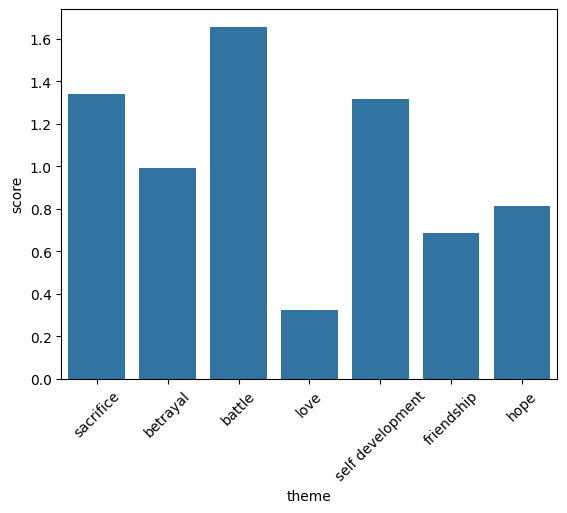

In [65]:
sns.barplot(data = theme_output ,x="theme",y="score" )
plt.xticks(rotation=45)
plt.show()